In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define the path to the dataset
base_dir = r"Downloads/archive/Combined_Dataset/train"
class_names = ["Mild_Impairment", "Moderate_Impairment", "No_Impairment", "Very_Mild_Impairment"]

In [ ]:
def load_image(file_path, target_size):
    img = Image.open(file_path).convert('L')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array

def load_dataset(base_dir, class_names, target_size):
    data, labels = [], []
    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Directory not found: {class_dir}")
            continue
        for file in os.listdir(class_dir):
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    img = load_image(file_path, target_size)
                    data.append(img)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")
    return np.array(data), np.array(labels)

In [ ]:
target_size = (128, 128)
X, y = load_dataset(base_dir, class_names, target_size)
if len(X) == 0:
    print("No images loaded. Please check the dataset.")
else:
    print(f"Loaded {len(X)} images.")
X = X.reshape(-1, 128, 128, 1)
y = np.array(y)

# Splitting dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Loaded 10240 images.


In [ ]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
# CNN Model for Feature Extraction
cnn_input = Input(shape=(128, 128, 1))
x = Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001))(cnn_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)  # Increased dropout

x = Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)

x = Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.5)(x)  # Increased dropout

x = Flatten()(x)
feature_output = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)

cnn_model = Model(inputs=cnn_input, outputs=feature_output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,960 (12.61 MB)

 Trainable params: 3,304,512 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Extract Features from CNN
X_train_features = cnn_model.predict(X_train)
X_val_features = cnn_model.predict(X_val)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Increased components for better variance retention
X_train_features = pca.fit_transform(X_train_features)
X_val_features = pca.transform(X_val_features)

# Base models with updated regularization
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, random_state=42)
xgb_model = XGBClassifier(n_estimators=150, learning_rate=0.03, max_depth=7, reg_lambda=2.0, gamma=0.1, random_state=42)
svm_model = SVC(kernel='rbf', C=0.8, probability=True)  # Adjusted C for better regularization

# Train base models on PCA-transformed features
rf.fit(X_train_features, y_train)
xgb_model.fit(X_train_features, y_train)
svm_model.fit(X_train_features, y_train)

256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


SVC(C=0.8, probability=True)

In [ ]:
# Meta-classifier
meta_model = LogisticRegression(C=0.05, penalty='l2', solver='lbfgs')  # Increased regularization

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb_model), ('svm', svm_model)],
    final_estimator=meta_model
)

# Train stacking model
stacking_model.fit(X_train_features, y_train)

# Predict and evaluate
train_preds = stacking_model.predict(X_train_features)
test_preds = stacking_model.predict(X_val_features)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_val, test_preds)

print(f"Stacking Model Training Accuracy: {train_acc * 100:.2f}%")
print(f"Stacking Model Test Accuracy: {test_acc * 100:.2f}%")

Stacking Model Training Accuracy: 96.94%
Stacking Model Test Accuracy: 90.77%


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_val, test_preds)
print(f"MCC: {mcc:.4f}")


MCC: 0.8770


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Predict class probabilities
y_prob = stacking_model.predict_proba(X_val_features)  # Get probability predictions

# Predict class labels
train_preds = stacking_model.predict(X_train_features)
test_preds = stacking_model.predict(X_val_features)

# Compute accuracy
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_val, test_preds)

# Compute ROC-AUC Score (One-vs-Rest for multi-class)
roc_auc = roc_auc_score(y_val, y_prob, multi_class='ovr')  

# Print results
print(f"Stacking Model Training Accuracy: {train_acc * 100:.2f}%")
print(f"Stacking Model Test Accuracy: {test_acc * 100:.2f}%")
print(f"Stacking Model ROC-AUC Score: {roc_auc:.4f}")  # Print ROC-AUC score


Stacking Model Training Accuracy: 96.94%
Stacking Model Test Accuracy: 90.77%
Stacking Model ROC-AUC Score: 0.9826


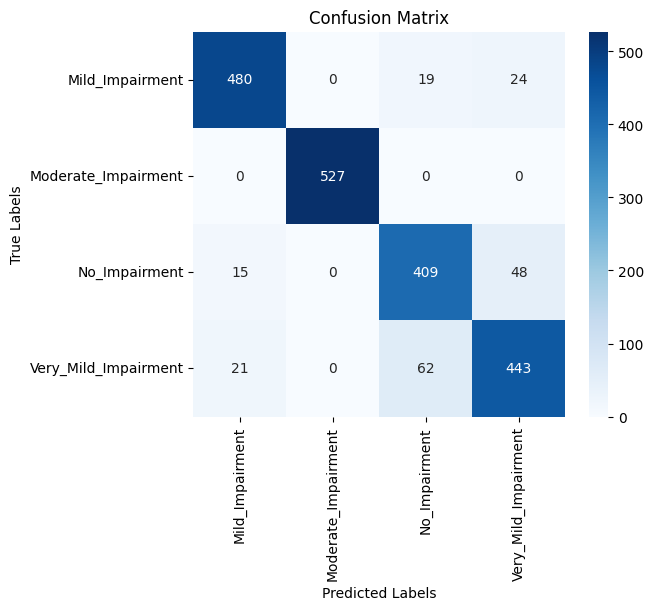

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_val, test_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_val, test_preds, target_names=class_names)

print("Classification Report:\n")
print(report)


Classification Report:

                      precision    recall  f1-score   support

     Mild_Impairment       0.93      0.92      0.92       523
 Moderate_Impairment       1.00      1.00      1.00       527
       No_Impairment       0.83      0.87      0.85       472
Very_Mild_Impairment       0.86      0.84      0.85       526

            accuracy                           0.91      2048
           macro avg       0.91      0.91      0.91      2048
        weighted avg       0.91      0.91      0.91      2048



In [ ]:
from sklearn.metrics import f1_score

# Compute F1-score
f1 = f1_score(y_val, test_preds, average='weighted')  # Use 'macro' or 'micro' as needed

print(f"F1 Score: {f1:.4f}")


F1 Score: 0.9078


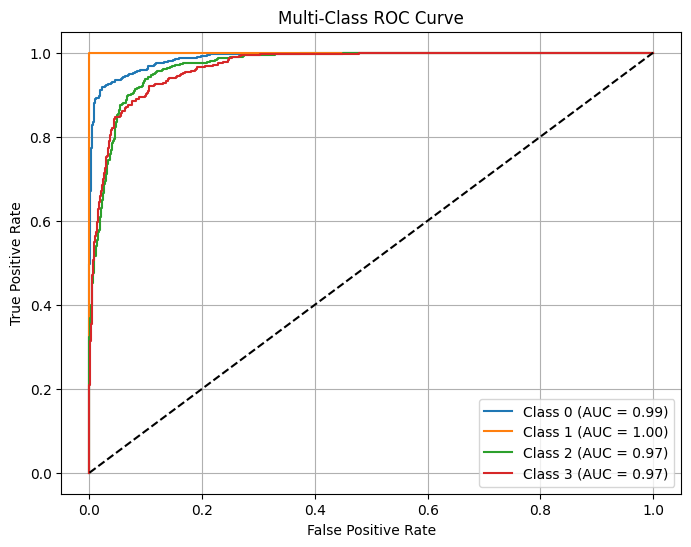

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3])  # Adjust classes based on your dataset
n_classes = y_val_bin.shape[1]

# Convert predictions to probability scores
y_score = stacking_model.predict_proba(X_val_features)

# Plot ROC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--')

# Graph settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
